=== Hyderabad Rainfall Prediction Model ===
Initializing with rigorous temporal validation...

=== Rigorous Data Validation ===
Training Years: [np.int64(2019), np.int64(2020), np.int64(2021)]
Testing Year:  2022

Date Ranges:
Training: 2019-01-08 to 2021-12-31
Testing:  2022-01-08 to 2022-12-31

Sample Counts:
Training: 1,075 samples
Testing:  358 samples

Class Distributions:
Training Set:
PRECTOTCORR_binary
1    0.583256
0    0.416744
Name: proportion, dtype: float64

Testing Set:
PRECTOTCORR_binary
1    0.561453
0    0.438547
Name: proportion, dtype: float64

After SMOTE balancing:
PRECTOTCORR_binary
0    627
1    627
Name: count, dtype: int64

Final input shapes:
X_train: (1239, 15, 14), y_train: (1239,)
X_test:  (343, 15, 14), y_test:  (343,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 14)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 14)    │     30,222 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 14)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 14)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 14)    │         28 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 15, 128)   │      1,920 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 15, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15, 14)    │      1,806 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 14)    │     30,222 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 15, 14)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 15, 128)   │      1,920 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 15, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 15, 14)    │      1,806 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 15, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 14)    │         28 │ add_4[0][0]     

 Total params: 95,145 (371.66 KB)

 Trainable params: 95,145 (371.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5692 - auc: 0.5087 - loss: 1.8077 - precision: 0.6025 - recall: 0.8311 - val_accuracy: 0.1169 - val_auc: 0.4635 - val_loss: 1.8559 - val_precision: 0.1169 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5959 - auc: 0.5994 - loss: 1.6673 - precision: 0.6199 - recall: 0.8146 - val_accuracy: 0.2016 - val_auc: 0.5946 - val_loss: 1.8009 - val_precision: 0.1211 - val_recall: 0.9310 - learning_rate: 1.0000e-04
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6814 - auc: 0.7105 - loss: 1.5673 - precision: 0.6933 - recall: 0.8438 - val_accuracy: 0.7500 - val_auc: 0.6249 - val_loss: 1.4792 - val_precision: 0.1333 - val_recall: 0.2069 - learning_rate: 1.0000e-04
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7609 - auc: 0.8111 - loss: 1.4576 - precision: 0.7740 - recall: 0.8629 - val_accuracy: 0.8226 - val_auc: 0.6694 - val_loss: 

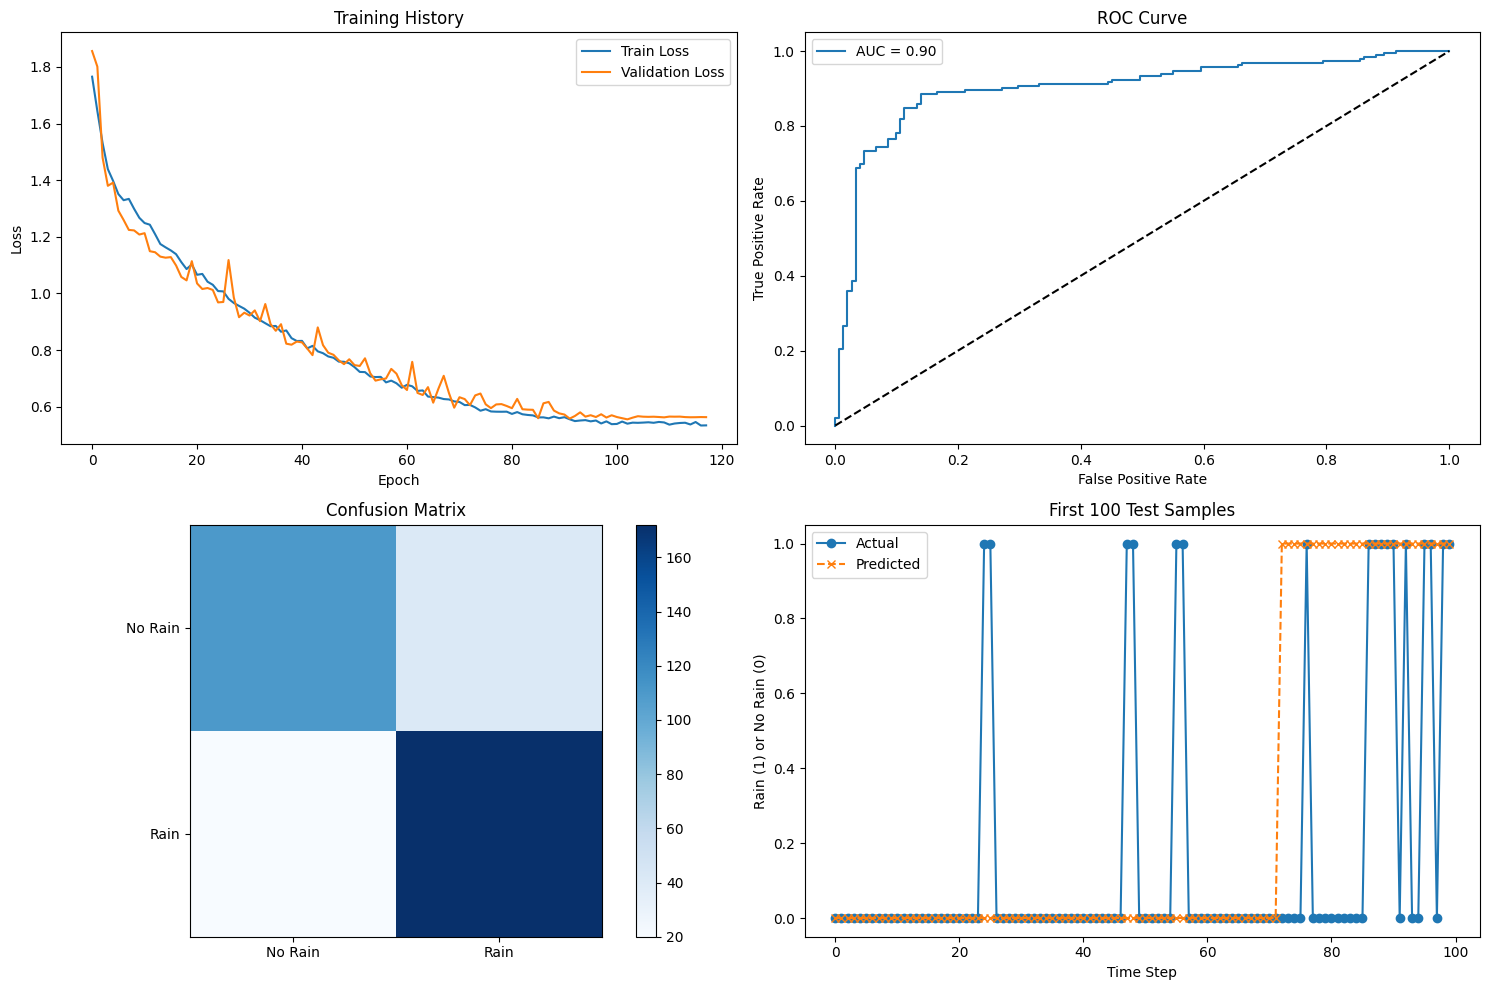


=== 7-Day Rainfall Forecast for Hyderabad ===
Day 1: No Rain
Day 2: No Rain
Day 3: No Rain
Day 4: No Rain
Day 5: No Rain
Day 6: No Rain
Day 7: No Rain


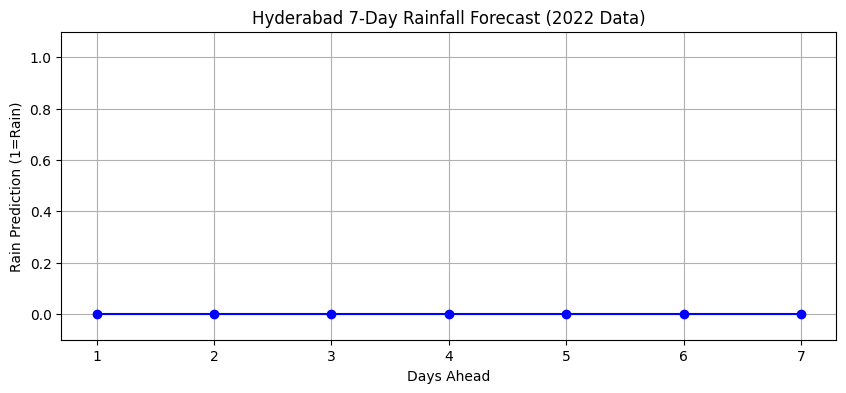

In [1]:
#for rainfall in hyderabad using transformer model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf

# Enhanced version with rigorous temporal validation

def load_and_prepare_data():
    try:
        # Load individual year datasets with validation
        df_2019 = pd.read_csv('C:\\Users\\priya\\main_rainfall_prediction\\Rainfall_prediction\\datatsets\\hyderabad_2019.csv').assign(YEAR=2019)
        df_2020 = pd.read_csv('C:\\Users\\priya\\main_rainfall_prediction\\Rainfall_prediction\\datatsets\\hyderabad_2020.csv').assign(YEAR=2020)
        df_2021 = pd.read_csv('C:\\Users\\priya\\main_rainfall_prediction\\Rainfall_prediction\\datatsets\\hyderabad_2021.csv').assign(YEAR=2021)
        df_2022 = pd.read_csv('C:\\Users\\priya\\main_rainfall_prediction\\Rainfall_prediction\\datatsets\\hyderabad_2022.csv').assign(YEAR=2022)
        
        # Verify year consistency in each file
        for year, df in zip([2019, 2020, 2021, 2022], [df_2019, df_2020, df_2021, df_2022]):
            if not (df['YEAR'] == year).all():
                raise ValueError(f"Inconsistent year data in {year} file")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading CSV files: {e}")

    # Combine data with rigorous checks
    full_df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
    
    # Data quality validation
    required_cols = ['YEAR', 'MO', 'DY', 'PRECTOTCORR']
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert and clean data with validation
    for col in required_cols:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')
        if full_df[col].isnull().any():
            print(f"Warning: NaN values found in {col} after conversion")
    full_df.dropna(subset=required_cols, inplace=True)

    # Create datetime with validation
    full_df['datetime'] = pd.to_datetime(dict(year=full_df['YEAR'], 
                                       month=full_df['MO'], 
                                       day=full_df['DY']), errors='coerce')
    if full_df['datetime'].isnull().any():
        raise ValueError("Invalid date values found in the data")
    
    # Temporal features
    full_df['DOY'] = full_df['datetime'].dt.dayofyear
    full_df['sin_DOY'] = np.sin(2 * np.pi * full_df['DOY'] / 365.25)
    full_df['cos_DOY'] = np.cos(2 * np.pi * full_df['DOY'] / 365.25)

    # Lag features with boundary checks
    for lag in [1, 3, 7]:
        full_df[f'PRECTOTCORR_lag{lag}'] = full_df.groupby('YEAR')['PRECTOTCORR'].shift(lag)
    
    # Hyderabad-specific elevation adjustment
    hyderabad_elevation = 505.5  # meters
    full_df['SLT'] = full_df['TS'] + (0.0065 * hyderabad_elevation)
    full_df.dropna(inplace=True)

    # Feature selection
    features = ['SLT', 'SLP', 'T2M', 'TS', 'T2M_MAX', 'T2M_MIN', 
               'RH2M', 'WS10M_MAX', 'WS10M_MIN',
               'sin_DOY', 'cos_DOY', 
               'PRECTOTCORR_lag1', 'PRECTOTCORR_lag3', 'PRECTOTCORR_lag7']
    target = 'PRECTOTCORR'
    full_df['PRECTOTCORR_binary'] = (full_df[target] > 0).astype(int)

    # Rigorous year-based splitting
    train_years = {2019, 2020, 2021}  # Using set for unambiguous membership testing
    test_year = 2022
    
    # Verify no overlap between train and test years
    if test_year in train_years:
        raise ValueError("Test year appears in training set!")
    
    train_df = full_df[full_df['YEAR'].isin(train_years)].copy()
    test_df = full_df[full_df['YEAR'] == test_year].copy()
    
    # Temporal integrity checks
    max_train_date = train_df['datetime'].max()
    min_test_date = test_df['datetime'].min()
    
    if min_test_date <= max_train_date:
        raise ValueError(f"Temporal leakage detected! Latest training date ({max_train_date}) >= earliest test date ({min_test_date})")
    
    # Data distribution validation
    print("\n=== Rigorous Data Validation ===")
    print("Training Years:", sorted(train_df['YEAR'].unique()))
    print("Testing Year: ", test_df['YEAR'].unique()[0])
    print("\nDate Ranges:")
    print(f"Training: {train_df['datetime'].min().date()} to {train_df['datetime'].max().date()}")
    print(f"Testing:  {test_df['datetime'].min().date()} to {test_df['datetime'].max().date()}")
    print("\nSample Counts:")
    print(f"Training: {len(train_df):,} samples")
    print(f"Testing:  {len(test_df):,} samples")
    
    # Verify no date overlaps
    train_dates = set(train_df['datetime'].dt.date)
    test_dates = set(test_df['datetime'].dt.date)
    if train_dates & test_dates:
        raise ValueError(f"Found {len(train_dates & test_dates)} overlapping dates between train and test sets!")
    
    print("\nClass Distributions:")
    print("Training Set:")
    print(train_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    print("\nTesting Set:")
    print(test_df['PRECTOTCORR_binary'].value_counts(normalize=True))
    
    return train_df, test_df, features, 'PRECTOTCORR_binary'

# Step 2: Balance and Scale Data
def preprocess_and_balance_data(train_df, test_df, features, target):
    # Initialize scaler and scale features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features])
    test_scaled = scaler.transform(test_df[features])

    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train_scaled, train_df[target])
    
    # Create balanced DataFrames
    train_balanced = pd.DataFrame(X_resampled, columns=features)
    train_balanced[target] = y_resampled
    
    test_processed = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
    test_processed[target] = test_df[target]
    test_processed['DOY'] = test_df['DOY']  # Preserve for sequence generation
    
    print("\nAfter SMOTE balancing:")
    print(train_balanced[target].value_counts())
    
    return train_balanced, test_processed, scaler

# Step 3: Create Time Sequences
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Step 4: Build Transformer Model
def build_transformer_model(seq_length, n_features):
    inputs = Input(shape=(seq_length, n_features))
    
    # Positional Encoding
    positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    positions = positions / tf.math.pow(10000, 2 * (tf.range(n_features, dtype=tf.float32) // 2) / n_features)
    positions = tf.reshape(positions, (1, seq_length, n_features))
    x = inputs + positions

    # Transformer Block 1
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    attention_output = Dropout(0.3)(attention_output)
    out1 = Add()([x, attention_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    # Feed Forward Network
    ffn = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out1)
    ffn = Dropout(0.3)(ffn)
    ffn = Dense(n_features, kernel_regularizer=l2(0.01))(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    # Transformer Block 2
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(out2, out2)
    attention_output = Dropout(0.3)(attention_output)
    out3 = Add()([out2, attention_output])
    out3 = LayerNormalization(epsilon=1e-6)(out3)
    
    ffn = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out3)
    ffn = Dropout(0.3)(ffn)
    ffn = Dense(n_features, kernel_regularizer=l2(0.01))(ffn)
    out4 = Add()([out3, ffn])
    out4 = LayerNormalization(epsilon=1e-6)(out4)

    # Output Layer
    x = Flatten()(out4)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy', 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

# Step 5: Train and Evaluate
def train_and_evaluate(seq_length=15):
    # Load and prepare data
    train_df, test_df, features, target = load_and_prepare_data()
    
    # Preprocess and balance
    train_balanced, test_processed, scaler = preprocess_and_balance_data(
        train_df, test_df, features, target)
    
    # Create sequences
    X_train, y_train = create_sequences(train_balanced, features, target, seq_length)
    X_test, y_test = create_sequences(test_processed, features, target, seq_length)
    
    print(f"\nFinal input shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

    # Build and train model
    model = build_transformer_model(seq_length, len(features))
    
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(X_train, y_train,
                       epochs=200,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=callbacks,
                       verbose=1)

    # Evaluate on test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1:        {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_prob):.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot results
    plot_results(history, y_test, y_pred_prob, y_pred)
    
    return model, scaler, test_processed, features, target

def plot_results(history, y_test, y_pred_prob, y_pred):
    plt.figure(figsize=(15, 10))
    
    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['No Rain', 'Rain'])
    plt.yticks([0, 1], ['No Rain', 'Rain'])
    
    # Actual vs Predicted
    plt.subplot(2, 2, 4)
    plt.plot(y_test[:100], 'o-', label='Actual')
    plt.plot(y_pred[:100], 'x--', label='Predicted')
    plt.title('First 100 Test Samples')
    plt.xlabel('Time Step')
    plt.ylabel('Rain (1) or No Rain (0)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Step 6: Make Future Predictions
def make_predictions(model, scaler, test_data, features, seq_length, days=7):
    last_sequence = test_data[features].iloc[-seq_length:].values
    predictions = []
    last_doy = test_data['DOY'].iloc[-1]
    
    for _ in range(days):
        x = last_sequence.reshape(1, seq_length, len(features))
        pred_prob = model.predict(x, verbose=0)[0][0]
        pred = 1 if pred_prob > 0.5 else 0
        predictions.append(pred)
        
        # Update sequence with predicted value
        new_row = last_sequence[-1].copy()
        new_row[-3] = pred_prob  # Update lag1 feature
        last_sequence = np.vstack([last_sequence[1:], new_row])
    
    return predictions
if __name__ == "__main__":
    seq_length = 15
    print("=== Hyderabad Rainfall Prediction Model ===")
    print("Initializing with rigorous temporal validation...")
    
    try:
        model, scaler, test_data, features, target = train_and_evaluate(seq_length)
        
        # Generate forecasts
        forecasts = make_predictions(model, scaler, test_data, features, seq_length)
        print("\n=== 7-Day Rainfall Forecast for Hyderabad ===")
        for day, pred in enumerate(forecasts, 1):
            print(f"Day {day}: {'Rain' if pred == 1 else 'No Rain'}")
        
        # Plot forecast
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, 8), forecasts, 'o-', color='blue')
        plt.title('Hyderabad 7-Day Rainfall Forecast (2022 Data)')
        plt.xlabel('Days Ahead')
        plt.ylabel('Rain Prediction (1=Rain)')
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        print("Model training failed due to data validation issues.")
